# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    tau = cst['tau_0']*np.exp(-cst['mu']*max(temps-(cst['N']-cst['t_0']),0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_moins
    DI_plus = cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_plus
    DR_moins = cst['gamma_IR']*I_moins-cst['lambda_2']*R_moins
    DR_plus_I = cst['gamma_IR']*I_plus+cst['lambda_2']*R_moins
    DH = cst['gamma_IH']*(I_moins + I_plus)-(cst['gamma_HR']+cst['gamma_HD']+cst['gamma_HU'])*H
    DU = cst['gamma_IU']*(I_moins + I_plus)+cst['gamma_HU']*H-(cst['gamma_UR'] + cst['gamma_UD'])*U
    DR_plus_H = cst['gamma_HR']*H+cst['gamma_UR']*U
    DD = cst['gamma_UD']*U+cst['gamma_HD']*H  
    DD_R = (cst['lambda_1']+cst['gamma_IH']+cst['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


Text(0, 0.5, 'Nombre de personne en réanimation')

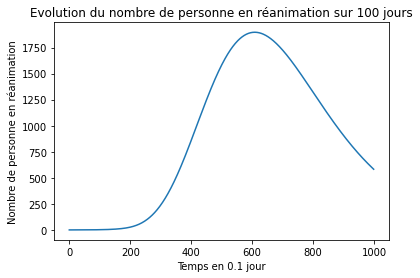

In [3]:
# Analyse des résultats

cst = init_constant()
syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,t)
plt.plot(simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {T_MAX} jours")
plt.xlabel(f"Temps en {deltaT} jour")
plt.ylabel("Nombre de personne en réanimation")




2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [4]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 10000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur 10000 simulation")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        cst = init_constant()
        syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0]) 
        simulation=odeint(equa_diff,syst_CI,t)           
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*deltaT))
        pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


Echantillonnage de Monte Carlo sur 10000 simulation


100% |########################################################################|


La valeur moyenne du pic est de 3502.82 et appartient à l'intervalle de confiance à 95% suivant : [3103.95,3901.7] 
 Le quantile à 10% du pic de réanimation est : 0.7837154822556396
 Le quantile à 90% du pic de réanimation est : 2842.5791446469875


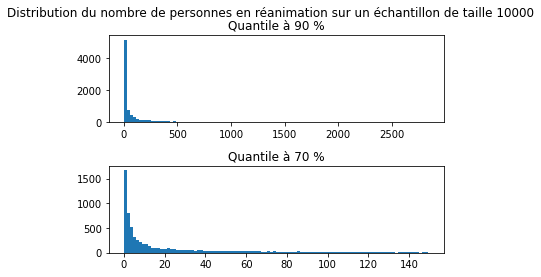

In [11]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if value < q_70], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


0.00028548404763550786


(array([3277.42907211, 3090.94097721, 2892.54938689, 2436.24872915,
        2376.73125205, 2158.5005027 , 2055.33687573, 1995.81939864,
        1535.55090909, 1626.81104064, 1301.44883251, 1273.67400986,
        1055.44326051, 1011.79711064,  968.15096077,  801.5020249 ,
         892.76215645,  753.88804322,  726.11322058,  634.85308903,
         591.20693916,  519.78596664,  515.81813484,  452.33282593,
         353.13703077,  357.10486258,  376.94402161,  337.26570355,
         269.81256284,  261.87689922,  190.45592671,  230.13424477,
         230.13424477,  138.87411323,  194.42375852,  142.84194503,
         150.77760864,  162.68110406,  103.16362697,   79.35663613,
         130.93844961,   99.19579516,   95.22796335,   75.38880432,
          83.32446794,   83.32446794,   27.77482265,   59.5174771 ,
          43.64614987,   35.71048626,   35.71048626,   27.77482265,
          31.74265445,   23.80699084,   23.80699084,   27.77482265,
          35.71048626,   23.80699084,    7.93566

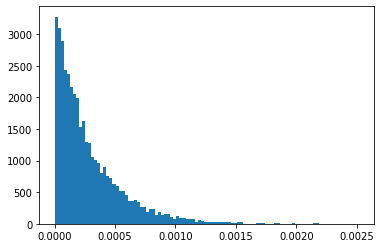

In [12]:
lbd = 1/mean_value
print(lbd)
Y = np.random.exponential(lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 52.43 et appartient à l'intervalle de confiance à 95% suivant : [52.01,52.85] 
 Le quantile à 10% du pic de réanimation est : 28.0
 Le quantile à 90% du pic de réanimation est : 87.0


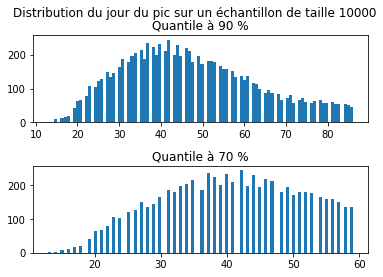

In [13]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

# Calibration

In [138]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [125]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination['date'] = pd.to_datetime(contamination['date'],infer_datetime_format = True)
contamination = contamination[contamination['date']<= '2020-05-11']
contamination.columns = [jour,'detecte']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

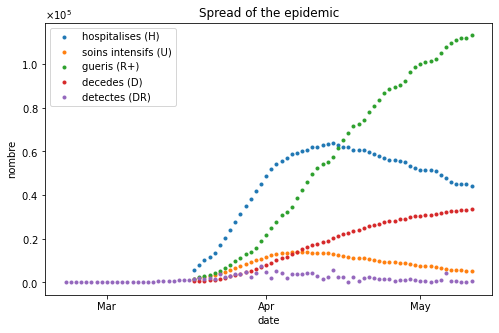

In [139]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')